# GDP Forecasting Analysis

This notebook implements a complete GDP forecasting workflow using the `GDPForecaster` module. We'll walk through the following steps:

1. Setup Environment
2. Load Historical Data
3. Train the Model
4. Run Rolling Backtests
5. Analyze Feature Importance
6. Generate GDP Forecast
7. Create Visualizations
8. Generate Report

Let's get started!

## 1. Setup Environment

First, let's import the necessary libraries and ensure our path is set correctly.

In [19]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from datetime import datetime
from pathlib import Path

# Check if we are inside the "notebooks" folder and move one level up
script_dir = os.path.dirname(os.path.abspath("__file__"))
if "notebooks" in script_dir:
    parent_dir = os.path.dirname(script_dir)
    os.chdir(parent_dir)

# Ensure the package is in the path
if not any(p.endswith(os.path.abspath(".")) for p in sys.path):
    sys.path.insert(0, os.path.abspath("."))

# Import our forecaster module
from utils.gdp_forecaster import GDPForecaster
from utils.utils import generate_report

print(f"Current working directory: {os.getcwd()}")
print(f"Python version: {sys.version}")

Current working directory: /Users/ignasipascual/Documents/GitHub/GDP-Forecaster
Python version: 3.9.6 (default, Nov 11 2024, 03:15:38) 
[Clang 16.0.0 (clang-1600.0.26.6)]


## 2. Configuration

Let's set up some configuration parameters for our analysis.

In [20]:
# Configuration parameters
COUNTRY_CODE = "USA"  # Change this to analyze different countries
FORECAST_HORIZON = 5  # Number of years to forecast
BACKTEST_YEARS = 3    # Number of years for backtesting
RUN_ROLLING_BACKTESTS = True  # Whether to run rolling backtests

# Setup output directory
RESULTS_DIR = Path("results") / COUNTRY_CODE
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Results will be saved to: {RESULTS_DIR}")

Results will be saved to: results/USA


## 3. Load Historical Data

Now we'll initialize the GDP forecaster and load historical data for our selected country.

In [21]:
# Initialize forecaster
forecaster = GDPForecaster()

# Load historical data
print(f"Loading historical data for {COUNTRY_CODE}...")
historical_data = forecaster.load_data(COUNTRY_CODE)
print(f"Loaded {len(historical_data)} years of historical data")

# Display a preview of the historical data
historical_data.tail(5)

2025-03-13 19:23:38,491 - data_collector - INFO - Loading cached World Bank data for USA


Loading historical data for USA...
Loaded 64 years of historical data


,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD.ZG,SP.POP.TOTL,SI.POV.GINI,NE.EXP.GNFS.ZS,NE.IMP.GNFS.ZS,BX.KLT.DINV.WD.GD.ZS,GC.DOD.TOTL.GD.ZS,SL.UEM.TOTL.ZS,FP.CPI.TOTL.ZG,GB.XPD.RSDV.GD.ZS,SH.XPD.CHEX.GD.ZS,SE.XPD.TOTL.GD.ZS,EG.USE.PCAP.KG.OE,NV.IND.TOTL.ZS,NV.SRV.TOTL.ZS,NV.AGR.TOTL.ZS
year,,,,,,,,,,,,,,,,,
2019-01-01,2.153998e+13,2.583825,328329953,41.5,11.789197,14.469283,1.466965,100.032349,3.669,1.812210,3.17049,16.665806,4.95747,NaN,18.145484,76.611371,0.832621
2020-01-01,2.135410e+13,-2.163029,331526933,39.7,10.073656,13.006122,0.641872,124.550891,8.055,1.233584,3.46777,18.756220,5.39998,NaN,17.267677,77.063050,0.935800
2021-01-01,2.368117e+13,6.055053,332048977,39.7,10.790978,14.422678,2.009212,118.450756,5.349,4.697859,3.45705,17.362568,5.42830,NaN,17.608172,76.399594,0.944733
2022-01-01,2.600689e+13,2.512375,333271411,41.3,11.602228,15.289462,1.572591,112.889633,3.650,8.002800,NaN,16.571152,NaN,NaN,NaN,NaN,NaN
2023-01-01,2.772071e+13,2.887556,334914895,NaN,11.011511,13.887852,1.258207,114.877163,3.638,4.116338,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's visualize the historical GDP data to get a sense of the trend.

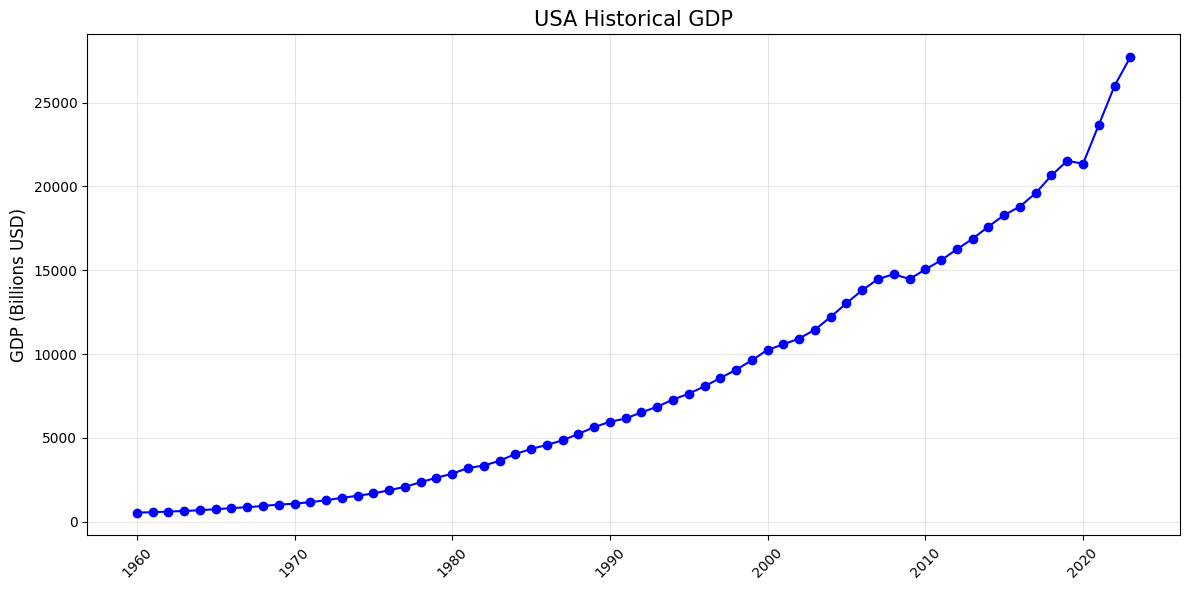

In [22]:
# Plot historical GDP
plt.figure(figsize=(12, 6))
historical_gdp = historical_data['NY.GDP.MKTP.CD'].dropna()

plt.plot(historical_gdp.index, historical_gdp.values / 1e9, 'o-', color='blue')
plt.title(f'{COUNTRY_CODE} Historical GDP', fontsize=15)
plt.ylabel('GDP (Billions USD)', fontsize=12)
plt.grid(True, alpha=0.3)

# Format x-axis to show years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 4. Train the Model

Now, let's train the ElasticNet model on the historical data.

In [23]:
# Train the model
print(f"Training the model with {BACKTEST_YEARS} years for testing...")
metrics = forecaster.train_model(test_years=BACKTEST_YEARS)

# Display metrics
print("\nModel Test Performance:")
print(f"MAPE: {metrics['MAPE']:.2f}%")
print(f"RMSE: ${metrics['RMSE']/1e9:.2f} billion")
print(f"R-squared: {metrics['R2']:.4f}")

Training the model with 3 years for testing...
Features used for training: ['NY.GDP.MKTP.KD.ZG', 'SP.POP.TOTL', 'SI.POV.GINI', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'BX.KLT.DINV.WD.GD.ZS', 'GC.DOD.TOTL.GD.ZS', 'SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GB.XPD.RSDV.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SE.XPD.TOTL.GD.ZS', 'EG.USE.PCAP.KG.OE', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'NV.AGR.TOTL.ZS']


2025-03-13 19:23:41,101 - gdp_forecaster - INFO - Best parameters: {'model__alpha': 1.0, 'model__l1_ratio': 0.5, 'model__selection': 'cyclic', 'model__tol': 0.0001}


Best hyperparameters found: {'model__alpha': 1.0, 'model__l1_ratio': 0.5, 'model__selection': 'cyclic', 'model__tol': 0.0001}

Model Test Performance:
MAPE: 19.86%
RMSE: $5398.48 billion
R-squared: -9.6346


## 5. Run Rolling Backtests

Let's perform rolling backtests to evaluate the model's predictive performance over time.

In [24]:
if RUN_ROLLING_BACKTESTS:
    print(f"Running rolling backtests for the last {BACKTEST_YEARS} years...")
    backtest_results = forecaster.run_rolling_backtests(n_years=BACKTEST_YEARS)
    
    if not backtest_results.empty:
        # Calculate aggregate metrics
        mape = np.mean(np.abs(backtest_results['Percent_Error']))
        rmse = np.sqrt(np.mean(backtest_results['Error'] ** 2))
        
        # Update metrics dictionary
        metrics.update({
            'Backtest_MAPE': mape,
            'Backtest_RMSE': rmse
        })
        
        print("\nRolling Backtest Performance:")
        print(f"MAPE: {mape:.2f}%")
        print(f"RMSE: ${rmse/1e9:.2f} billion")
        
        # Display backtest results
        backtest_results

2025-03-13 19:23:41,111 - gdp_forecaster - INFO - Running backtest for year 2021
2025-03-13 19:23:41,224 - gdp_forecaster - INFO - Best parameters: {'model__alpha': 1.0, 'model__l1_ratio': 0.5, 'model__selection': 'cyclic', 'model__tol': 0.0001}


Running rolling backtests for the last 3 years...
Features used for training: ['NY.GDP.MKTP.KD.ZG', 'SP.POP.TOTL', 'SI.POV.GINI', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'BX.KLT.DINV.WD.GD.ZS', 'GC.DOD.TOTL.GD.ZS', 'SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GB.XPD.RSDV.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SE.XPD.TOTL.GD.ZS', 'EG.USE.PCAP.KG.OE', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'NV.AGR.TOTL.ZS']
Best hyperparameters found: {'model__alpha': 1.0, 'model__l1_ratio': 0.5, 'model__selection': 'cyclic', 'model__tol': 0.0001}


2025-03-13 19:23:41,860 - gdp_forecaster - INFO -   Actual: 23681171000000.00, Predicted: 21902417618132.70, Error: 1778753381867.30 (7.51%)
2025-03-13 19:23:41,860 - gdp_forecaster - INFO - Running backtest for year 2022
2025-03-13 19:23:41,977 - gdp_forecaster - INFO - Best parameters: {'model__alpha': 1.0, 'model__l1_ratio': 0.2, 'model__selection': 'cyclic', 'model__tol': 0.0001}


Features used for training: ['NY.GDP.MKTP.KD.ZG', 'SP.POP.TOTL', 'SI.POV.GINI', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'BX.KLT.DINV.WD.GD.ZS', 'GC.DOD.TOTL.GD.ZS', 'SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GB.XPD.RSDV.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SE.XPD.TOTL.GD.ZS', 'EG.USE.PCAP.KG.OE', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'NV.AGR.TOTL.ZS']
Best hyperparameters found: {'model__alpha': 1.0, 'model__l1_ratio': 0.2, 'model__selection': 'cyclic', 'model__tol': 0.0001}


2025-03-13 19:23:42,670 - gdp_forecaster - INFO -   Actual: 26006893000000.00, Predicted: 21246433101683.63, Error: 4760459898316.37 (18.30%)
2025-03-13 19:23:42,671 - gdp_forecaster - INFO - Running backtest for year 2023
2025-03-13 19:23:42,791 - gdp_forecaster - INFO - Best parameters: {'model__alpha': 1.0, 'model__l1_ratio': 0.5, 'model__selection': 'cyclic', 'model__tol': 0.0001}


Features used for training: ['NY.GDP.MKTP.KD.ZG', 'SP.POP.TOTL', 'SI.POV.GINI', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'BX.KLT.DINV.WD.GD.ZS', 'GC.DOD.TOTL.GD.ZS', 'SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GB.XPD.RSDV.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SE.XPD.TOTL.GD.ZS', 'EG.USE.PCAP.KG.OE', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'NV.AGR.TOTL.ZS']
Best hyperparameters found: {'model__alpha': 1.0, 'model__l1_ratio': 0.5, 'model__selection': 'cyclic', 'model__tol': 0.0001}


2025-03-13 19:23:43,432 - gdp_forecaster - INFO -   Actual: 27720709000000.00, Predicted: 21889318160769.73, Error: 5831390839230.27 (21.04%)
2025-03-13 19:23:43,433 - gdp_forecaster - INFO - Backtest Results - MAPE: 15.62%, RMSE: 4465835537979.48



Rolling Backtest Performance:
MAPE: 15.62%
RMSE: $4465.84 billion


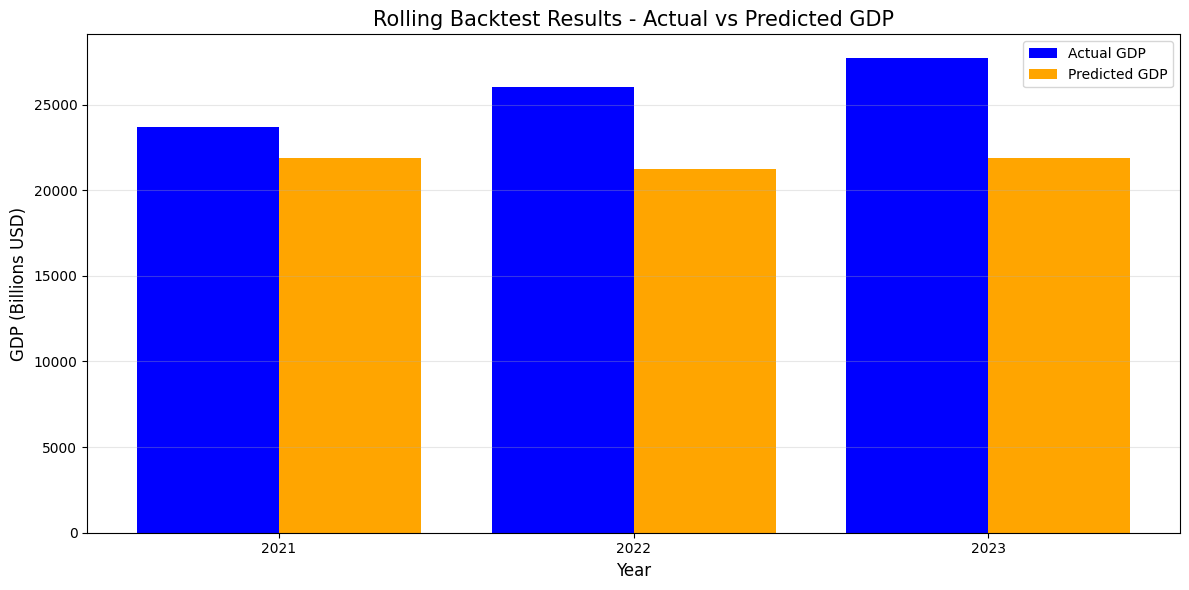

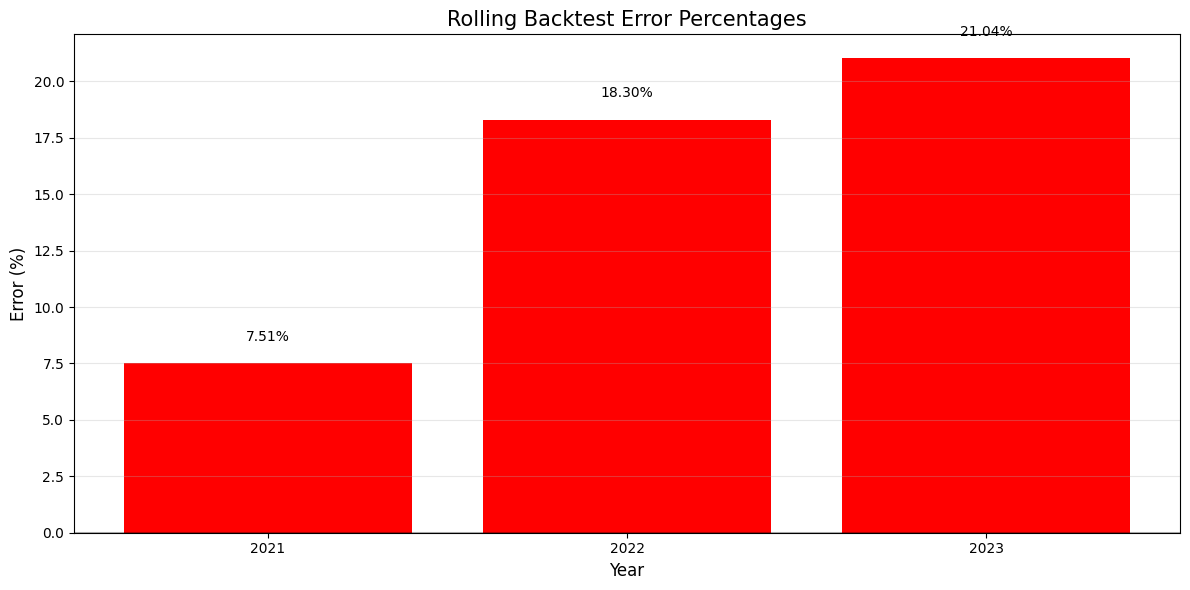

In [36]:
if RUN_ROLLING_BACKTESTS and not backtest_results.empty:
    plt.figure(figsize=(12, 6))
    
    # Create years for x-axis
    years = backtest_results.index.astype(int)
    
    # Plot actual vs predicted
    plt.bar(years - 0.2, backtest_results['Actual'] / 1e9, width=0.4, color='blue', label='Actual GDP')
    plt.bar(years + 0.2, backtest_results['Predicted'] / 1e9, width=0.4, color='orange', label='Predicted GDP')
    
    plt.title('Rolling Backtest Results - Actual vs Predicted GDP', fontsize=15)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('GDP (Billions USD)', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.legend()
    
    # Set x-axis to only show years as integers
    plt.xticks(years)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x)}'))
    
    plt.tight_layout()
    plt.show()
    
    # Plot percent errors
    plt.figure(figsize=(12, 6))
    plt.bar(years, backtest_results['Percent_Error'], color=['green' if x < 0 else 'red' for x in backtest_results['Percent_Error']])
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.title('Rolling Backtest Error Percentages', fontsize=15)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Error (%)', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Set x-axis to only show years as integers
    plt.xticks(years)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x)}'))
    
    # Add error values as text
    for i, v in enumerate(backtest_results['Percent_Error']):
        plt.text(years[i], v + (1 if v > 0 else -1), 
                 f"{v:.2f}%", 
                 ha='center')
    
    plt.tight_layout()
    plt.show()

## 6. Analyze Feature Importance

Let's examine which economic indicators have the most influence on our GDP forecast.

Top 5 Most Important Features:
  1. SP.POP.TOTL: 10.47%
  2. NE.IMP.GNFS.ZS: 9.99%
  3. NE.EXP.GNFS.ZS: 9.06%
  4. SI.POV.GINI: 8.75%
  5. GC.DOD.TOTL.GD.ZS: 8.58%


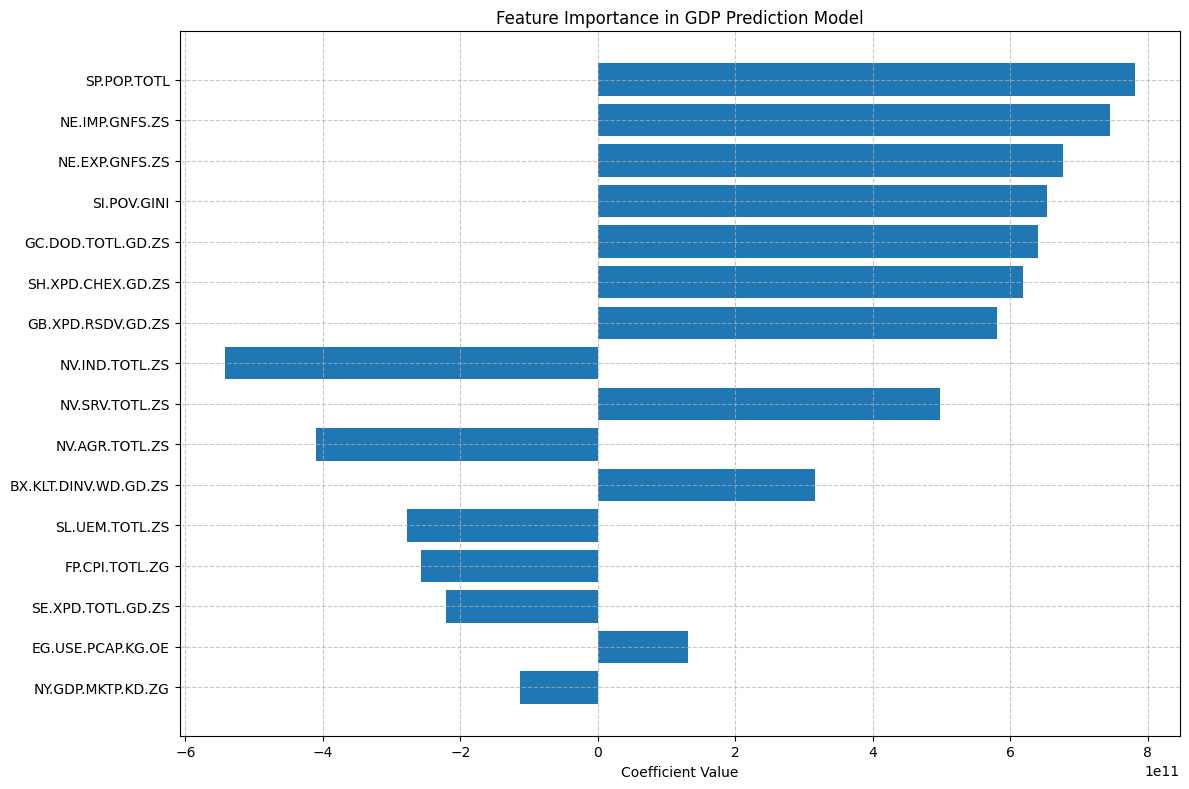

In [26]:
# Get feature importance
feature_importance = forecaster.get_model_coefficients()

# Display top features
print("Top 5 Most Important Features:")
top_features = feature_importance.head(5)
for i, (feature, importance) in enumerate(zip(top_features['Feature'], top_features['Normalized_Importance'])):
    print(f"  {i+1}. {feature}: {importance:.2%}")

# Create and display the feature importance plot using the forecaster's method
fig_importance = forecaster.plot_feature_importance()
plt.tight_layout()
plt.savefig(RESULTS_DIR / f"{COUNTRY_CODE}_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Plot feature importance - REMOVING THIS CELL
# We're now using forecaster.plot_feature_importance() in the previous cell instead
# This custom plot is no longer needed

## 6. Forecast Covariates and GDP

Let's forecast both the economic covariates and GDP values for the upcoming years.

In [28]:
# First, forecast the covariates (economic indicators)
print(f"Forecasting economic indicators for the next {FORECAST_HORIZON} years...")
forecasted_features = forecaster.forecast_features(horizon=FORECAST_HORIZON)

# Display forecasted features
print("\nForecasted Economic Indicators:")
forecasted_features

Forecasting economic indicators for the next 5 years...

Forecasted Economic Indicators:


,NY.GDP.MKTP.KD.ZG,SP.POP.TOTL,SI.POV.GINI,NE.EXP.GNFS.ZS,NE.IMP.GNFS.ZS,BX.KLT.DINV.WD.GD.ZS,GC.DOD.TOTL.GD.ZS,SL.UEM.TOTL.ZS,FP.CPI.TOTL.ZG,GB.XPD.RSDV.GD.ZS,SH.XPD.CHEX.GD.ZS,SE.XPD.TOTL.GD.ZS,EG.USE.PCAP.KG.OE,NV.IND.TOTL.ZS,NV.SRV.TOTL.ZS,NV.AGR.TOTL.ZS
2024-01-01,2.877081,3.365552e+08,41.358857,10.649653,13.850762,1.290724,115.805320,4.295695,1.636085,3.456130,16.754393,5.474308,6799.253196,17.538310,76.215416,0.913731
2025-01-01,2.349279,3.382036e+08,41.417654,10.811694,14.448763,1.431569,117.813550,4.866598,2.650036,3.462200,16.961168,5.455807,6795.757942,17.626894,76.227012,0.921458
2026-01-01,2.744370,3.398600e+08,41.476451,10.893119,14.371993,1.414146,118.749778,5.232882,3.748525,3.464029,16.986789,5.451712,6792.550761,17.555779,76.375741,0.940896
2027-01-01,2.380115,3.415246e+08,41.535248,10.808906,13.818029,1.485995,120.615576,5.444333,3.811709,3.464527,16.818369,5.467613,6789.798537,17.597329,76.281370,0.917484
2028-01-01,2.704236,3.431973e+08,41.594045,10.805391,13.994763,1.460745,121.552444,5.560595,3.498630,3.464662,16.634480,5.450362,6787.390532,17.582309,76.209616,0.921433


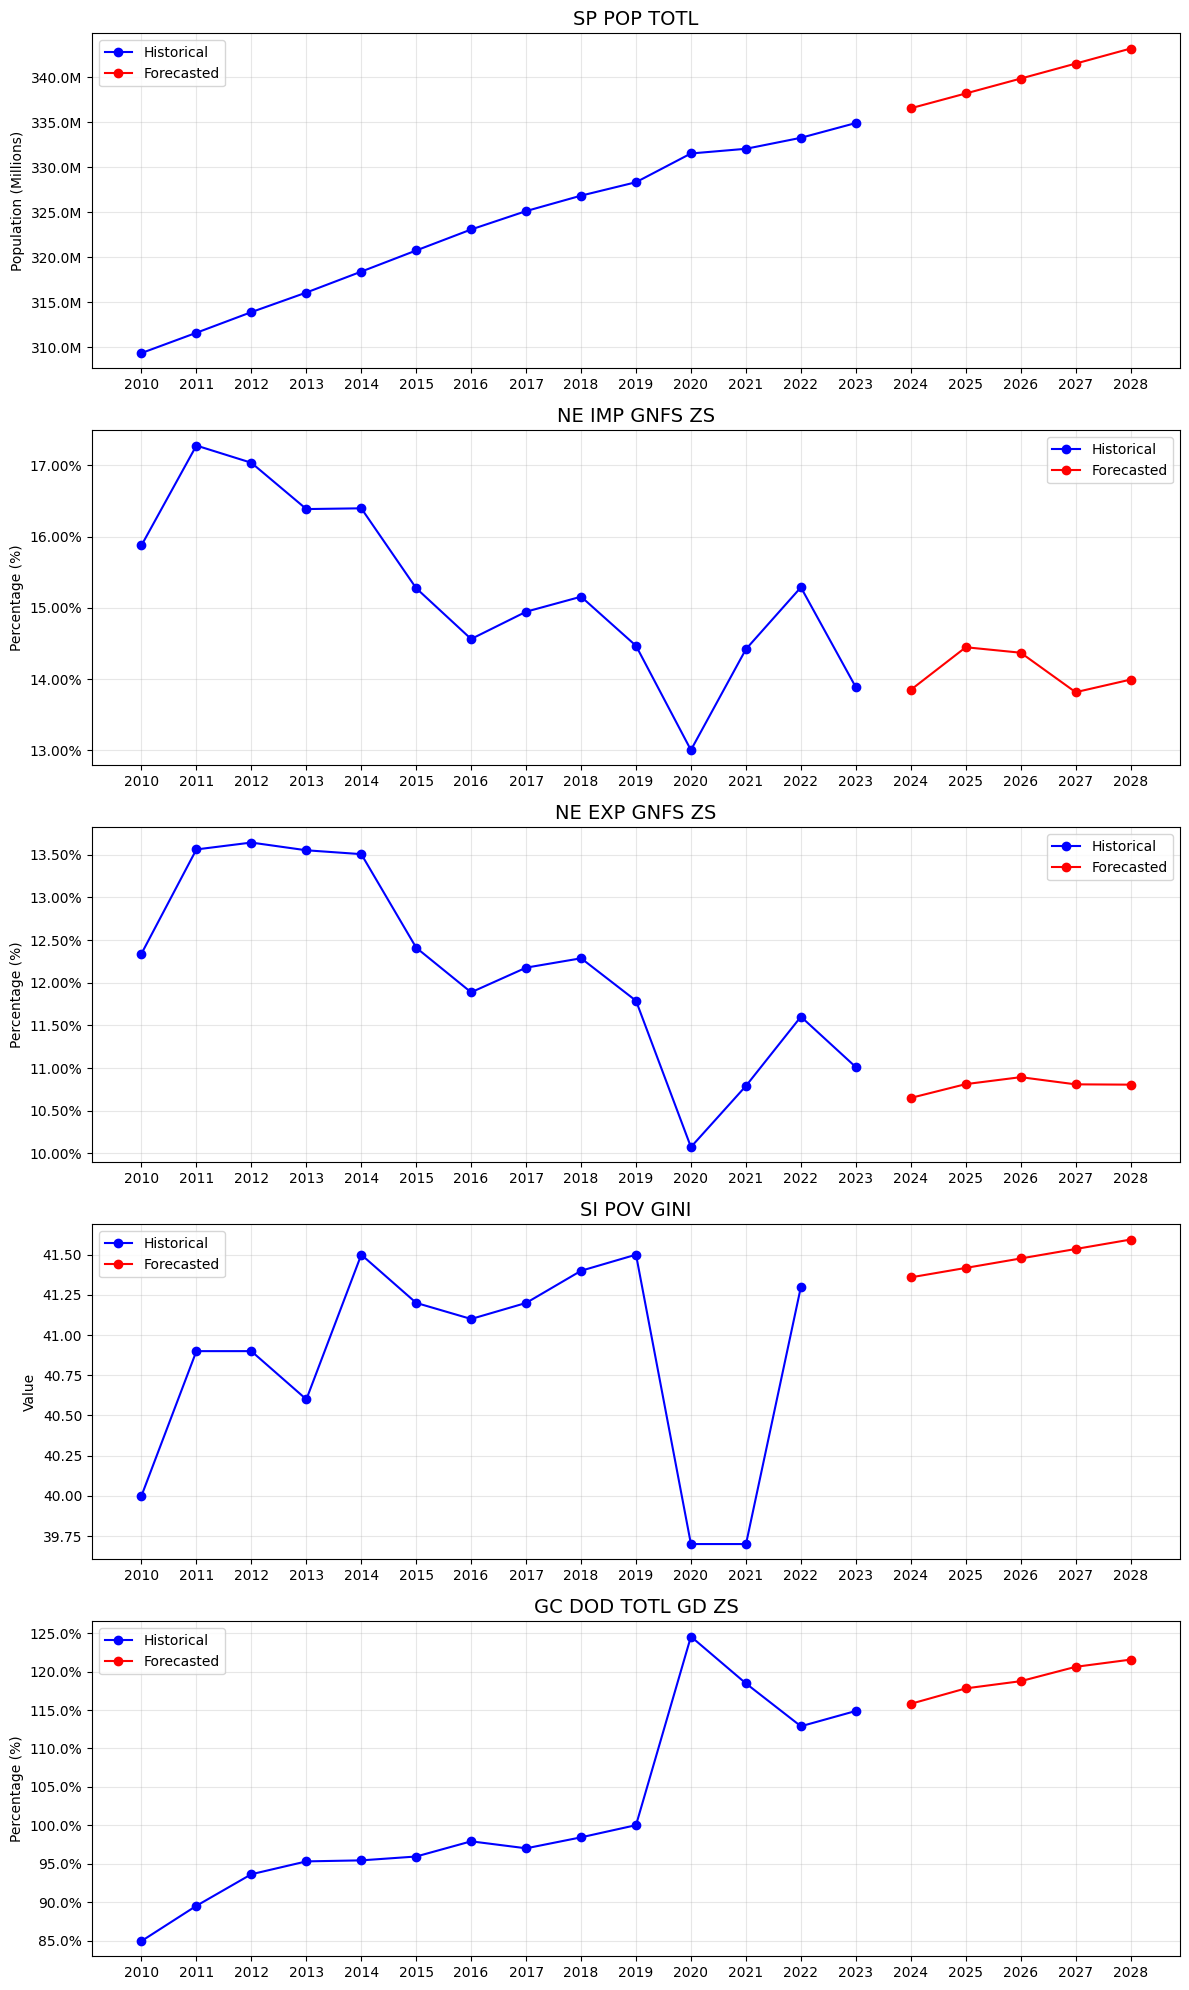

In [29]:
# Visualize key forecasted covariates
# Select a few important indicators to visualize
if len(forecasted_features.columns) > 0:
    # Select top 5 important features
    top_features = feature_importance.head(5).reset_index(drop=True)
    key_indicators = list(top_features['Feature'])
    
    # Create a figure with subplots for each indicator
    fig, axes = plt.subplots(len(key_indicators), 1, figsize=(12, 4*len(key_indicators)))
    
    # If only one indicator, axes is not a list
    if len(key_indicators) == 1:
        axes = [axes]
    
    # Plot each indicator
    for i, feature in enumerate(key_indicators):
        # Get historical data
        historical_series = historical_data[feature].copy()
        
        # Get last 15 years of data
        current_year = datetime.now().year
        start_year = current_year - 15
        start_date = pd.Timestamp(f"{start_year}-01-01")
        
        # Filter data to the last 15 years
        if len(historical_series) > 15:
            historical_series = historical_series[historical_series.index >= start_date]
        
        # Get forecasted data
        forecasted_series = forecasted_features[feature]
        
        # Plot historical data
        axes[i].plot(historical_series.index, historical_series.values, 'o-', 
                    color='blue', label='Historical')
        
        # Plot forecasted data
        axes[i].plot(forecasted_series.index, forecasted_series.values, 'o-', 
                    color='red', label='Forecasted')
        
        # Format plot
        readable_name = feature.replace('.', ' ').replace('_', ' ')
        axes[i].set_title(f'{readable_name}', fontsize=14)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        
        # Format x-axis
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[i].xaxis.set_major_locator(mdates.YearLocator())
        
        # Format y-axis appropriately based on the indicator
        if 'PERCENT' in feature.upper() or 'RATE' in feature.upper() or 'ZS' in feature.upper() or 'ZG' in feature.upper():
            axes[i].yaxis.set_major_formatter(mtick.PercentFormatter())
            axes[i].set_ylabel('Percentage (%)')
        elif 'POP' in feature.upper():
            def millions(x, pos):
                return f'{x/1e6:.1f}M'
            axes[i].yaxis.set_major_formatter(plt.FuncFormatter(millions))
            axes[i].set_ylabel('Population (Millions)')
        else:
            axes[i].set_ylabel('Value')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"{COUNTRY_CODE}_key_indicators_forecast.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No forecasted features available to visualize.")

In [30]:
# Now that we have forecasted the covariates, let's forecast GDP
print(f"Forecasting GDP for the next {FORECAST_HORIZON} years using the forecasted economic indicators...")
gdp_forecast = forecaster.forecast_gdp(horizon=FORECAST_HORIZON)

# Display forecast
print("\nGDP Forecast:")
gdp_forecast

Forecasting GDP for the next 5 years using the forecasted economic indicators...

GDP Forecast:


,GDP_Forecast,Previous_GDP,Growth_Rate
2024-01-01,2.087381e+13,2.772071e+13,-24.699590
2025-01-01,2.105172e+13,2.087381e+13,0.852345
2026-01-01,2.094394e+13,2.105172e+13,-0.512001
2027-01-01,2.086307e+13,2.094394e+13,-0.386142
2028-01-01,2.086195e+13,2.086307e+13,-0.005348


In [31]:
# Try to get official IMF forecasts for comparison
try:
    print("Getting official IMF forecasts for comparison...")
    official_forecast = forecaster.get_official_forecasts()
    print("IMF Forecast:")
    print(official_forecast)
except Exception as e:
    print(f"Could not get official forecasts: {str(e)}")
    official_forecast = None

2025-03-13 19:23:46,178 - data_collector - INFO - Loading cached IMF forecast data for USA


Getting official IMF forecasts for comparison...
IMF Forecast:
            IMF_GDP_Growth
2025-01-01        2.354448
2026-01-01        2.065763
2027-01-01        2.481572
2028-01-01        2.056446


## 7. Create Visualizations

Let's use the built-in `plot_forecast` method to visualize GDP and growth rates.

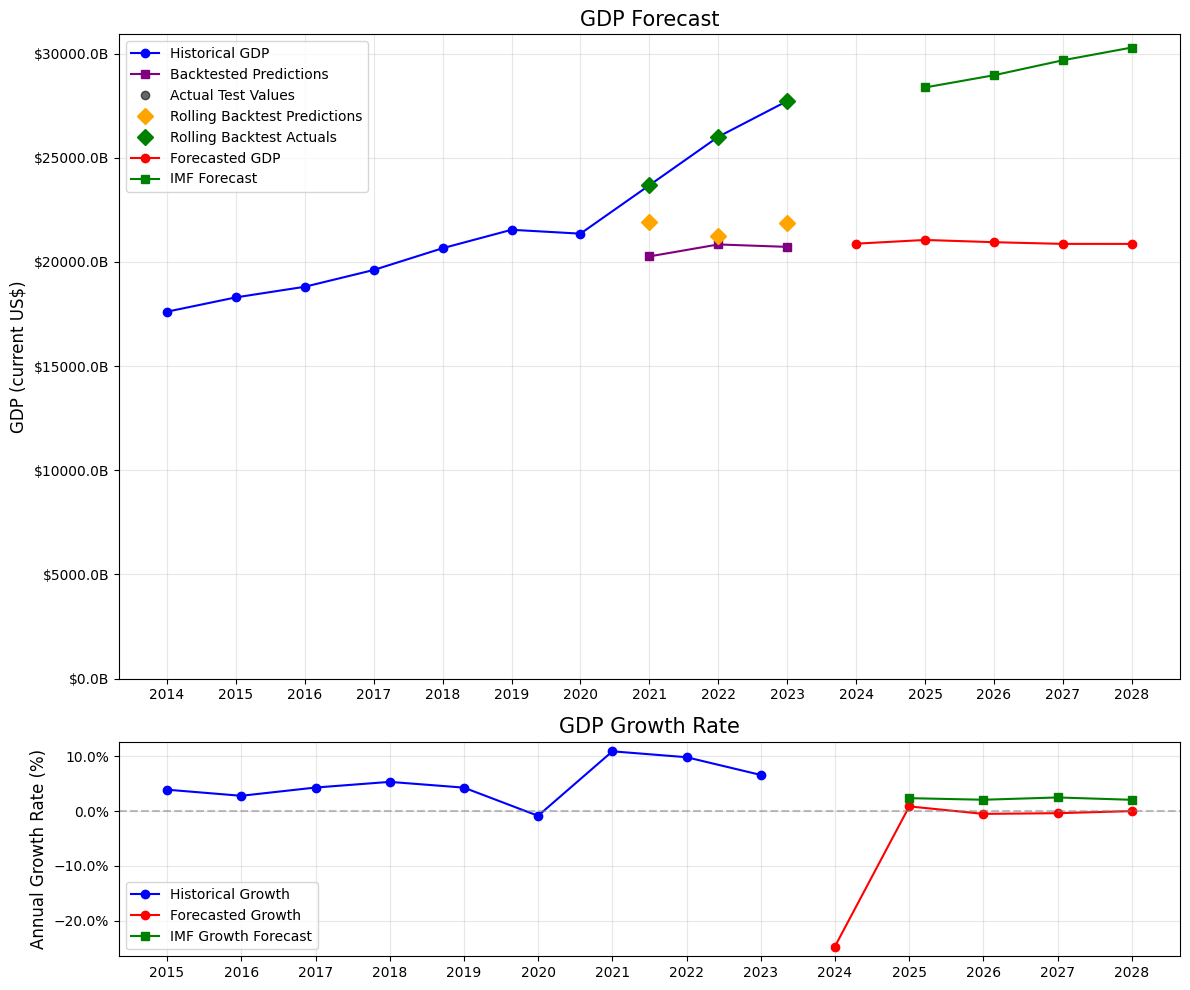

<Figure size 640x480 with 0 Axes>

In [32]:
# Use the built-in plot_forecast method to create GDP and growth rate plots
# This will show the past 10 years of history, backtested predictions, and future forecast
fig_forecast = forecaster.plot_forecast(show_history_years=10, include_backtests=True)
plt.savefig(RESULTS_DIR / f"{COUNTRY_CODE}_gdp_forecast.png", dpi=300, bbox_inches='tight')
plt.show()

# Also save standalone growth plot for the report
plt.savefig(RESULTS_DIR / f"{COUNTRY_CODE}_gdp_growth.png", dpi=300, bbox_inches='tight')

## 8. Export Data and Generate Report

Let's export the forecast data and generate the final report.

In [33]:
# Export forecast data
print(f"Exporting forecast data to {RESULTS_DIR}...")
forecaster.export_results(str(RESULTS_DIR))

# Generate HTML report
print("Generating HTML report...")
report_path = generate_report(
    country_code=COUNTRY_CODE,
    results_dir=RESULTS_DIR,
    metrics=metrics,
    gdp_forecast=gdp_forecast,
    feature_importance=feature_importance,
    forecast_horizon=FORECAST_HORIZON,
    backtest_years=BACKTEST_YEARS,
    backtest_results=forecaster.backtest_results if RUN_ROLLING_BACKTESTS else None
)

print(f"\nReport generated successfully at: {report_path}")

2025-03-13 19:23:46,862 - gdp_forecaster - INFO - GDP forecast exported to results/USA/USA_gdp_forecast.csv
2025-03-13 19:23:46,864 - gdp_forecaster - INFO - Feature forecasts exported to results/USA/USA_features_forecast.csv
2025-03-13 19:23:46,868 - gdp_forecaster - INFO - Forecast comparison exported to results/USA/USA_forecast_comparison.csv
2025-03-13 19:23:46,869 - gdp_forecaster - INFO - Historical data exported to results/USA/USA_historical_data.csv


Exporting forecast data to results/USA...


2025-03-13 19:23:47,276 - gdp_forecaster - INFO - Forecast plot saved to results/USA/USA_gdp_forecast_plot.png
2025-03-13 19:23:47,277 - gdp_forecaster - INFO - Rolling backtest results exported to results/USA/USA_rolling_backtest_results.csv


Generating HTML report...

Report generated successfully at: results/USA/USA_forecast_report.html


## 9. Summary and Conclusions

Let's summarize our findings and forecast results.

In [34]:
# Summarize forecast results
avg_growth = gdp_forecast['Growth_Rate'].mean()
total_growth = ((gdp_forecast['GDP_Forecast'].iloc[-1] / gdp_forecast['GDP_Forecast'].iloc[0]) - 1) * 100
first_year_gdp = gdp_forecast['GDP_Forecast'].iloc[0] / 1e9
last_year_gdp = gdp_forecast['GDP_Forecast'].iloc[-1] / 1e9

print(f"\n{'=' * 60}")
print(f"GDP FORECAST SUMMARY FOR {COUNTRY_CODE}")
print(f"{'=' * 60}\n")

print(f"Forecast Horizon: {FORECAST_HORIZON} years")
print(f"Average Annual Growth Rate: {avg_growth:.2f}%")
print(f"Total Growth Over Forecast Period: {total_growth:.2f}%")
print(f"GDP in {gdp_forecast.index[0].year}: ${first_year_gdp:.2f} billion")
print(f"GDP in {gdp_forecast.index[-1].year}: ${last_year_gdp:.2f} billion")

if 'Backtest_MAPE' in metrics:
    print(f"\nModel Backtesting Accuracy: {metrics['Backtest_MAPE']:.2f}% MAPE")

print(f"\nTop 3 Influential Features:")
for i, (feature, importance) in enumerate(zip(top_features['Feature'].iloc[-3:], top_features['Normalized_Importance'].iloc[-3:])):
    print(f"  {i+1}. {feature}: {importance:.2%}")

print(f"\n{'=' * 60}")
print(f"Forecast completed successfully! Results saved to: {RESULTS_DIR}")
print(f"{'=' * 60}")


GDP FORECAST SUMMARY FOR USA

Forecast Horizon: 5 years
Average Annual Growth Rate: -4.95%
Total Growth Over Forecast Period: -0.06%
GDP in 2024: $20873.81 billion
GDP in 2028: $20861.95 billion

Model Backtesting Accuracy: 15.62% MAPE

Top 3 Influential Features:
  1. NE.EXP.GNFS.ZS: 9.06%
  2. SI.POV.GINI: 8.75%
  3. GC.DOD.TOTL.GD.ZS: 8.58%

Forecast completed successfully! Results saved to: results/USA
